# 地震动记录处理 

## 处理流程：
1. 导入地震数据
2. 对所有数据进行预处理（基线校正、频率滤波、地震波截断、重采样）
3. 缩放到不同 PGA 序列（0.1g, 0.2g, 0.3g, ...）
4. 导出缩放后的数据
5. 绘制反应谱和波形对比图

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import copy

# 导入原有工具
from Utils.BatchReadPEER import BatchReadPEER

# 导入 ObsPy 增强工具
from Utils.obspy_processing import (
    create_trace_from_array,
    process_ground_motion,
    scale_to_pga,
    calculate_response_spectrum,
    export_processed_ground_motions,
    plot_all_waveforms_comparison,
    plot_all_response_spectra,
    plot_response_spectrum
)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print('所有库导入成功！')

所有库导入成功！


## 步骤 1: 导入地震数据

In [3]:
# 设置参数
FileFolder = r'peerNGA'

# 批量读取地震波（不进行缩放）
GMdata = BatchReadPEER(FileFolder, Scalsw=False)

print(f'共读取 {len(GMdata)} 组地震波')
print(f'第一条地震波信息：')
print(f'  RSN: {GMdata[0]["RSN"]}')
print(f'  采样时间步: {GMdata[0]["dt"]} s')
print(f'  数据点数: {GMdata[0]["npts"]}')
print(f'  原始 PGA (H1): {np.max(np.abs(GMdata[0]["GMH1"])):.4f} g')

RSN=171 已读取和存储完成，序号: 1，共 30 条
RSN=776 已读取和存储完成，序号: 2，共 30 条
RSN=806 已读取和存储完成，序号: 3，共 30 条
RSN=949 已读取和存储完成，序号: 4，共 30 条
RSN=959 已读取和存储完成，序号: 5，共 30 条
RSN=1044 已读取和存储完成，序号: 6，共 30 条
RSN=1045 已读取和存储完成，序号: 7，共 30 条
RSN=1048 已读取和存储完成，序号: 8，共 30 条
RSN=1158 已读取和存储完成，序号: 9，共 30 条
RSN=1176 已读取和存储完成，序号: 10，共 30 条
RSN=1194 已读取和存储完成，序号: 11，共 30 条
RSN=1481 已读取和存储完成，序号: 12，共 30 条
RSN=1498 已读取和存储完成，序号: 13，共 30 条
RSN=1602 已读取和存储完成，序号: 14，共 30 条
RSN=1605 已读取和存储完成，序号: 15，共 30 条
RSN=4207 已读取和存储完成，序号: 16，共 30 条
RSN=4853 已读取和存储完成，序号: 17，共 30 条
RSN=4856 已读取和存储完成，序号: 18，共 30 条
RSN=4860 已读取和存储完成，序号: 19，共 30 条
RSN=4875 已读取和存储完成，序号: 20，共 30 条
RSN=5774 已读取和存储完成，序号: 21，共 30 条
RSN=5781 已读取和存储完成，序号: 22，共 30 条
RSN=5836 已读取和存储完成，序号: 23，共 30 条
RSN=6013 已读取和存储完成，序号: 24，共 30 条
RSN=6886 已读取和存储完成，序号: 25，共 30 条
RSN=6897 已读取和存储完成，序号: 26，共 30 条
RSN=6927 已读取和存储完成，序号: 27，共 30 条
RSN=6952 已读取和存储完成，序号: 28，共 30 条
RSN=6960 已读取和存储完成，序号: 29，共 30 条
RSN=6962 已读取和存储完成，序号: 30，共 30 条
所有 30 组地震波已读取和存储完成
共读取 30 组地震波
第一条地震波信息：
  RSN: 171
  

## 步骤 2: 对所有地震波进行预处理

预处理包括：
- 基线校正（去均值 + 线性去趋势）
- 带通滤波（0.1-25 Hz）
- 地震波截断（保留 5%-95% 能量持时）
- 重采样到 100 Hz

In [4]:
# 预处理参数
baseline_method = 'linear'      # 基线校正方法
filter_freq = (0.1, 25.0)       # 滤波频率范围 (Hz)
truncate = True                 # 是否截断
energy_threshold = (0.05, 0.95) # 能量阈值
resample_rate = 100.0           # 重采样率 (Hz)

# 存储处理后的数据
GMdata_processed = []
traces_original_list = []
traces_processed_list = []
rsn_list = []

print('开始预处理所有地震波...')

for i, gm in enumerate(GMdata):
    # 处理三个分量
    trace_h1_proc, trace_h1_orig, info_h1 = process_ground_motion(
        gm['GMH1'], gm['dt'],
        baseline_method=baseline_method,
        filter_freq=filter_freq,
        truncate=truncate,
        energy_threshold=energy_threshold,
        resample_rate=resample_rate
    )
    
    trace_h2_proc, trace_h2_orig, info_h2 = process_ground_motion(
        gm['GMH2'], gm['dt'],
        baseline_method=baseline_method,
        filter_freq=filter_freq,
        truncate=truncate,
        energy_threshold=energy_threshold,
        resample_rate=resample_rate
    )
    
    trace_v3_proc, trace_v3_orig, info_v3 = process_ground_motion(
        gm['GMV3'], gm['dt'],
        baseline_method=baseline_method,
        filter_freq=filter_freq,
        truncate=truncate,
        energy_threshold=energy_threshold,
        resample_rate=resample_rate
    )
    
    # 保存处理后的数据
    GMdata_processed.append({
        'RSN': gm['RSN'],
        'GMH1': trace_h1_proc,
        'GMH2': trace_h2_proc,
        'GMV3': trace_v3_proc,
        'GMname': gm['GMname'],
        'info': info_h1
    })
    
    # 保存用于绘图的数据（只保存H1分量）
    traces_original_list.append(trace_h1_orig)
    traces_processed_list.append(trace_h1_proc)
    rsn_list.append(gm['RSN'])
    
    if (i + 1) % 5 == 0:
        print(f'已处理 {i+1}/{len(GMdata)} 条地震波')

print(f'\n所有 {len(GMdata)} 条地震波预处理完成！')
print(f'\n示例 - 第一条地震波处理信息：')
print(f'  截断: {GMdata_processed[0]["info"]["truncated"]}')
if GMdata_processed[0]['info']['truncated']:
    print(f'  有效持时: {GMdata_processed[0]["info"]["duration"]:.2f} s')
print(f'  重采样: {GMdata_processed[0]["info"]["resampled"]}')
if GMdata_processed[0]['info']['resampled']:
    print(f'  新采样率: {GMdata_processed[0]["info"]["new_sampling_rate"]} Hz')

开始预处理所有地震波...
已处理 5/30 条地震波
已处理 10/30 条地震波
已处理 15/30 条地震波
已处理 20/30 条地震波
已处理 25/30 条地震波
已处理 30/30 条地震波

所有 30 条地震波预处理完成！

示例 - 第一条地震波处理信息：
  截断: True
  有效持时: 8.21 s
  重采样: True
  新采样率: 100.0 Hz


d:\ProgramData\miniconda3\envs\opss\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


## 步骤 3: 缩放到不同 PGA 并导出数据

将处理后的地震波缩放到不同的 PGA 水平

In [5]:
# 定义 PGA 序列
pga_values = np.arange(0.1, 1.1, 0.1)  # 0.1g 到 1.0g，步长 0.1g
# pga_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # 也可以手动指定

print(f'PGA 序列: {pga_values}')
print(f'\n开始导出数据...')

# 导出处理后并缩放的数据
export_processed_ground_motions(
    GMdata_processed, 
    pga_values, 
    base_dir='ground_motions/processed'
)

print('\n所有数据导出完成！')

PGA 序列: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

开始导出数据...
PGA = 0.10g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.10g
PGA = 0.20g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.20g
PGA = 0.30g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.30g
PGA = 0.40g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.40g
PGA = 0.50g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.50g
PGA = 0.60g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.60g
PGA = 0.70g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\OpenSeespy\bridges\GM\ground_motions\processed\PGA_0.70g
PGA = 0.80g 的数据已导出至: c:\Users\Administrator\Nutstore\1\我的坚果云\代码\活动\Open

## 步骤 4: 计算反应谱

为某个 PGA 水平计算所有地震波的反应谱

In [6]:
# 选择一个 PGA 进行反应谱计算
selected_pga = 0.5  # g

# 定义周期范围
periods = np.logspace(-2, 1, 100)  # 0.01s 到 10s
damping = 0.05  # 5% 阻尼比

print(f'正在计算 PGA={selected_pga}g 的反应谱...')

# 存储所有反应谱
all_Sa = []
all_Sv = []
all_Sd = []

for i, gm_proc in enumerate(GMdata_processed):
    # 缩放到目标 PGA
    acce_scaled, scale_factor = scale_to_pga(gm_proc['GMH1'].data, selected_pga)
    dt = gm_proc['GMH1'].stats.delta
    
    # 计算反应谱
    Sa, Sv, Sd = calculate_response_spectrum(
        acce_scaled, dt, periods, damping=damping
    )
    
    all_Sa.append(Sa)
    all_Sv.append(Sv)
    all_Sd.append(Sd)
    
    if (i + 1) % 5 == 0:
        print(f'已计算 {i+1}/{len(GMdata_processed)} 条地震波的反应谱')

all_Sa = np.array(all_Sa)
all_Sv = np.array(all_Sv)
all_Sd = np.array(all_Sd)

print(f'\n反应谱计算完成！')

正在计算 PGA=0.5g 的反应谱...
已计算 5/30 条地震波的反应谱
已计算 10/30 条地震波的反应谱
已计算 15/30 条地震波的反应谱
已计算 20/30 条地震波的反应谱
已计算 25/30 条地震波的反应谱
已计算 30/30 条地震波的反应谱

反应谱计算完成！


## 步骤 5: 绘制所有地震波的处理前后对比图

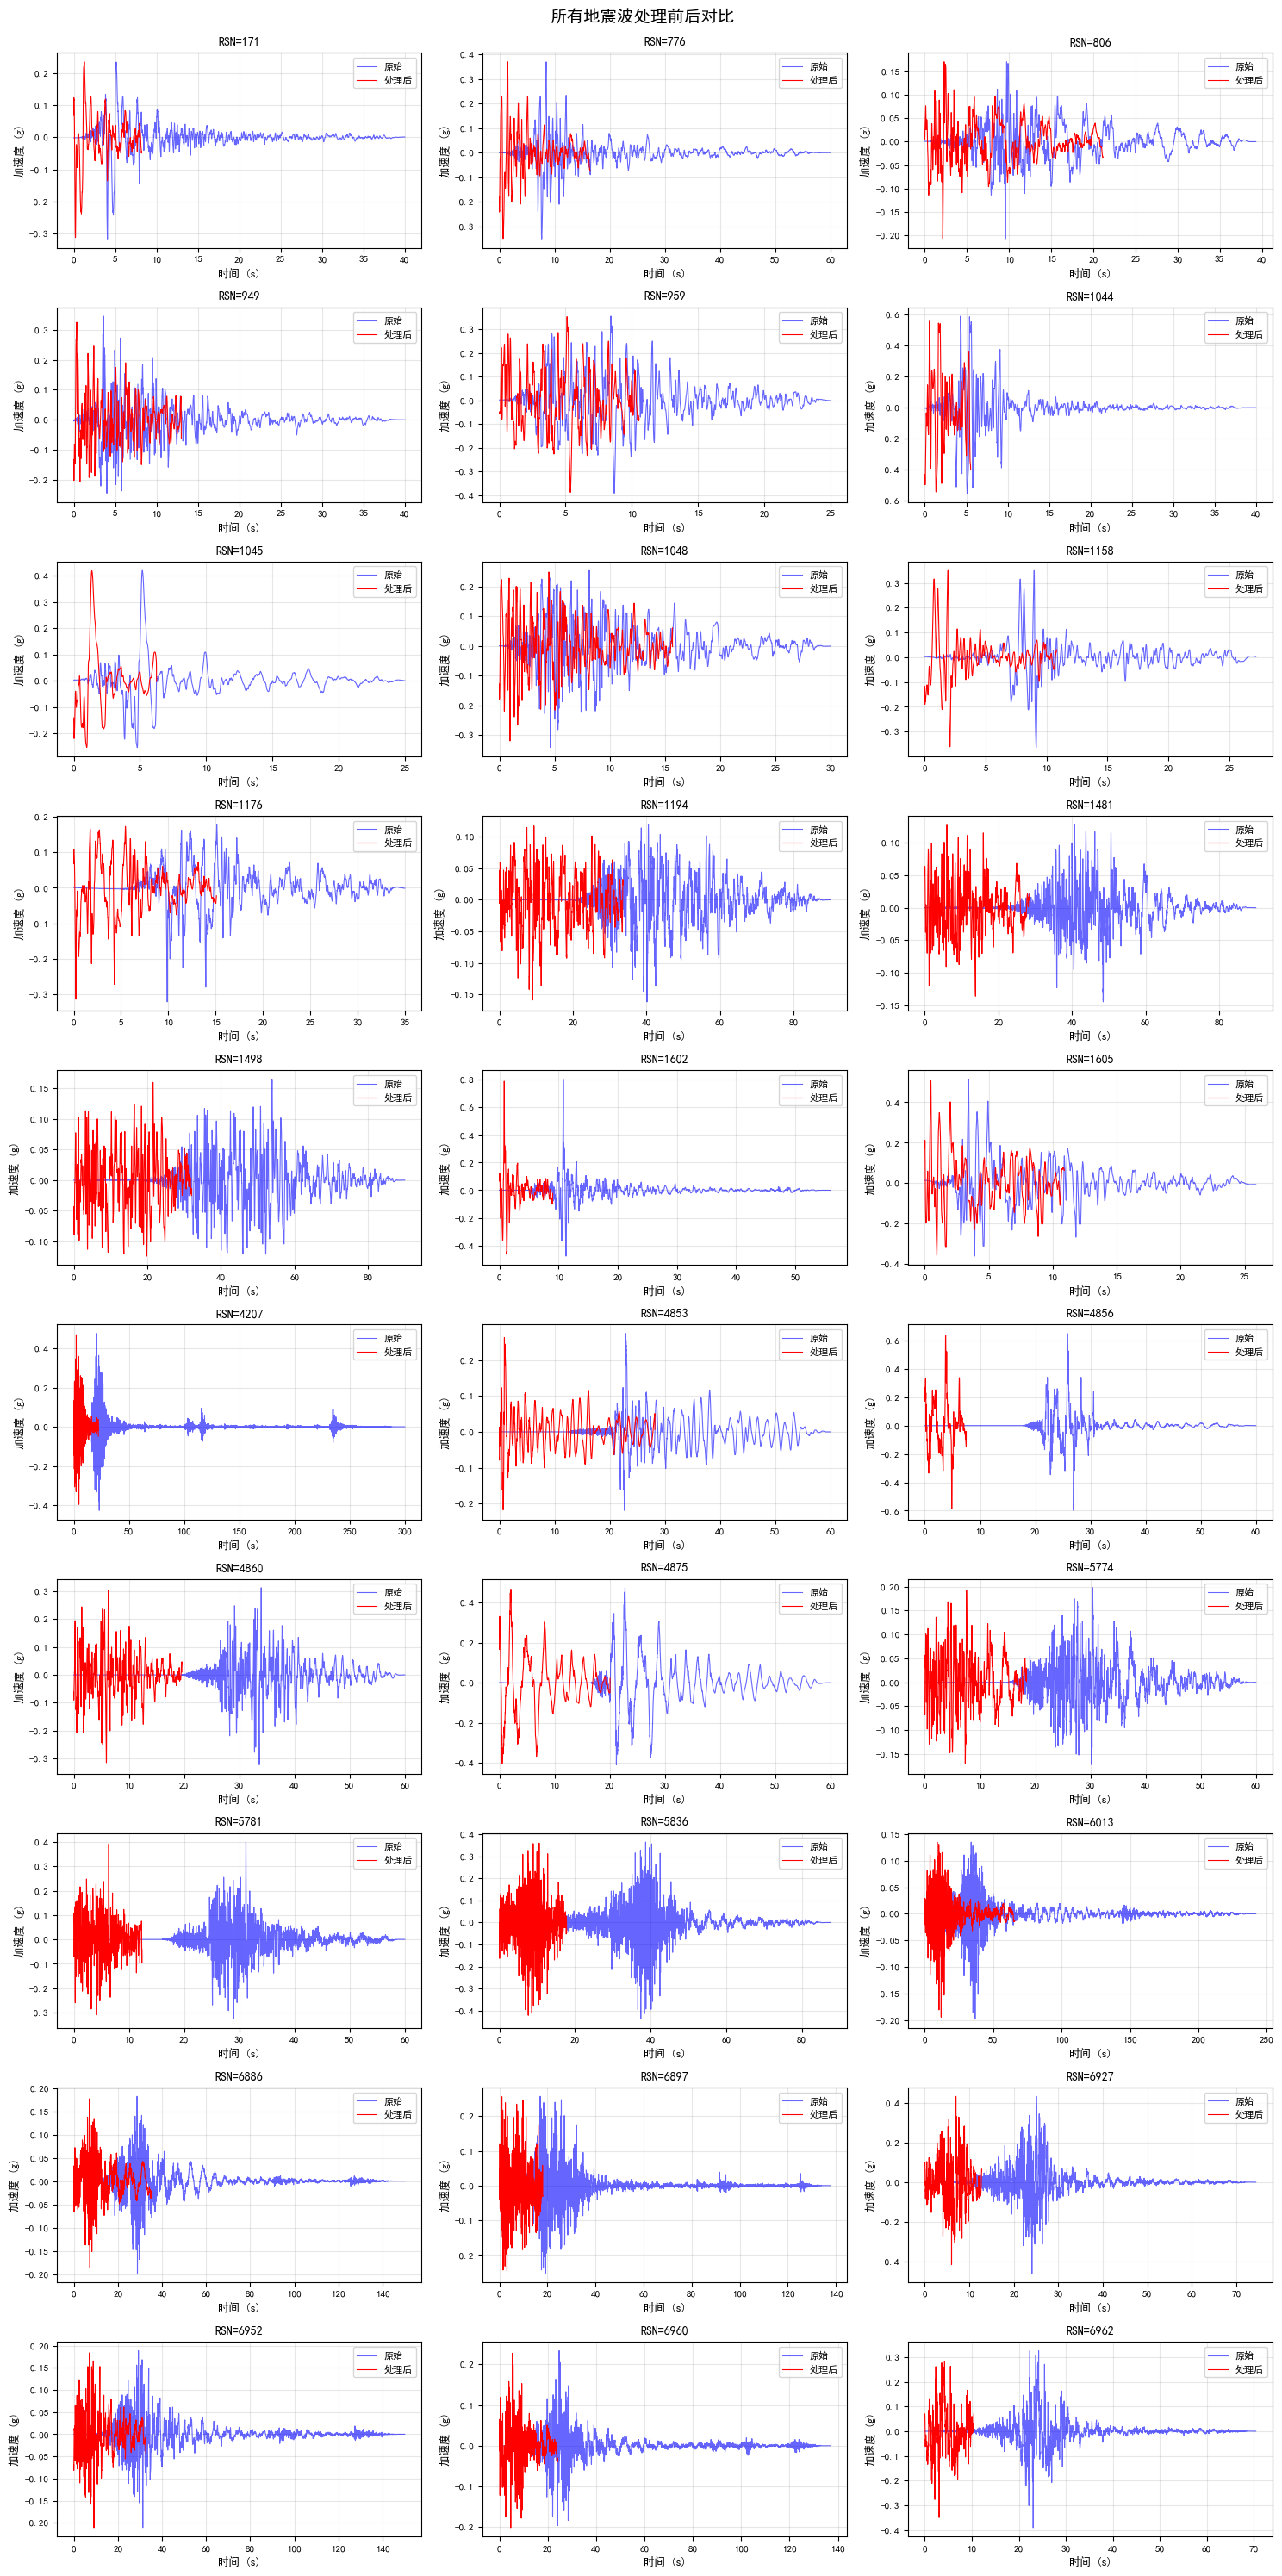

In [7]:
# 绘制所有地震波的处理前后对比（H1分量）
plot_all_waveforms_comparison(
    traces_original_list,
    traces_processed_list,
    rsn_list,
    save_path='ground_motions/waveforms_comparison.png'
)

## 步骤 6: 绘制所有地震波的反应谱

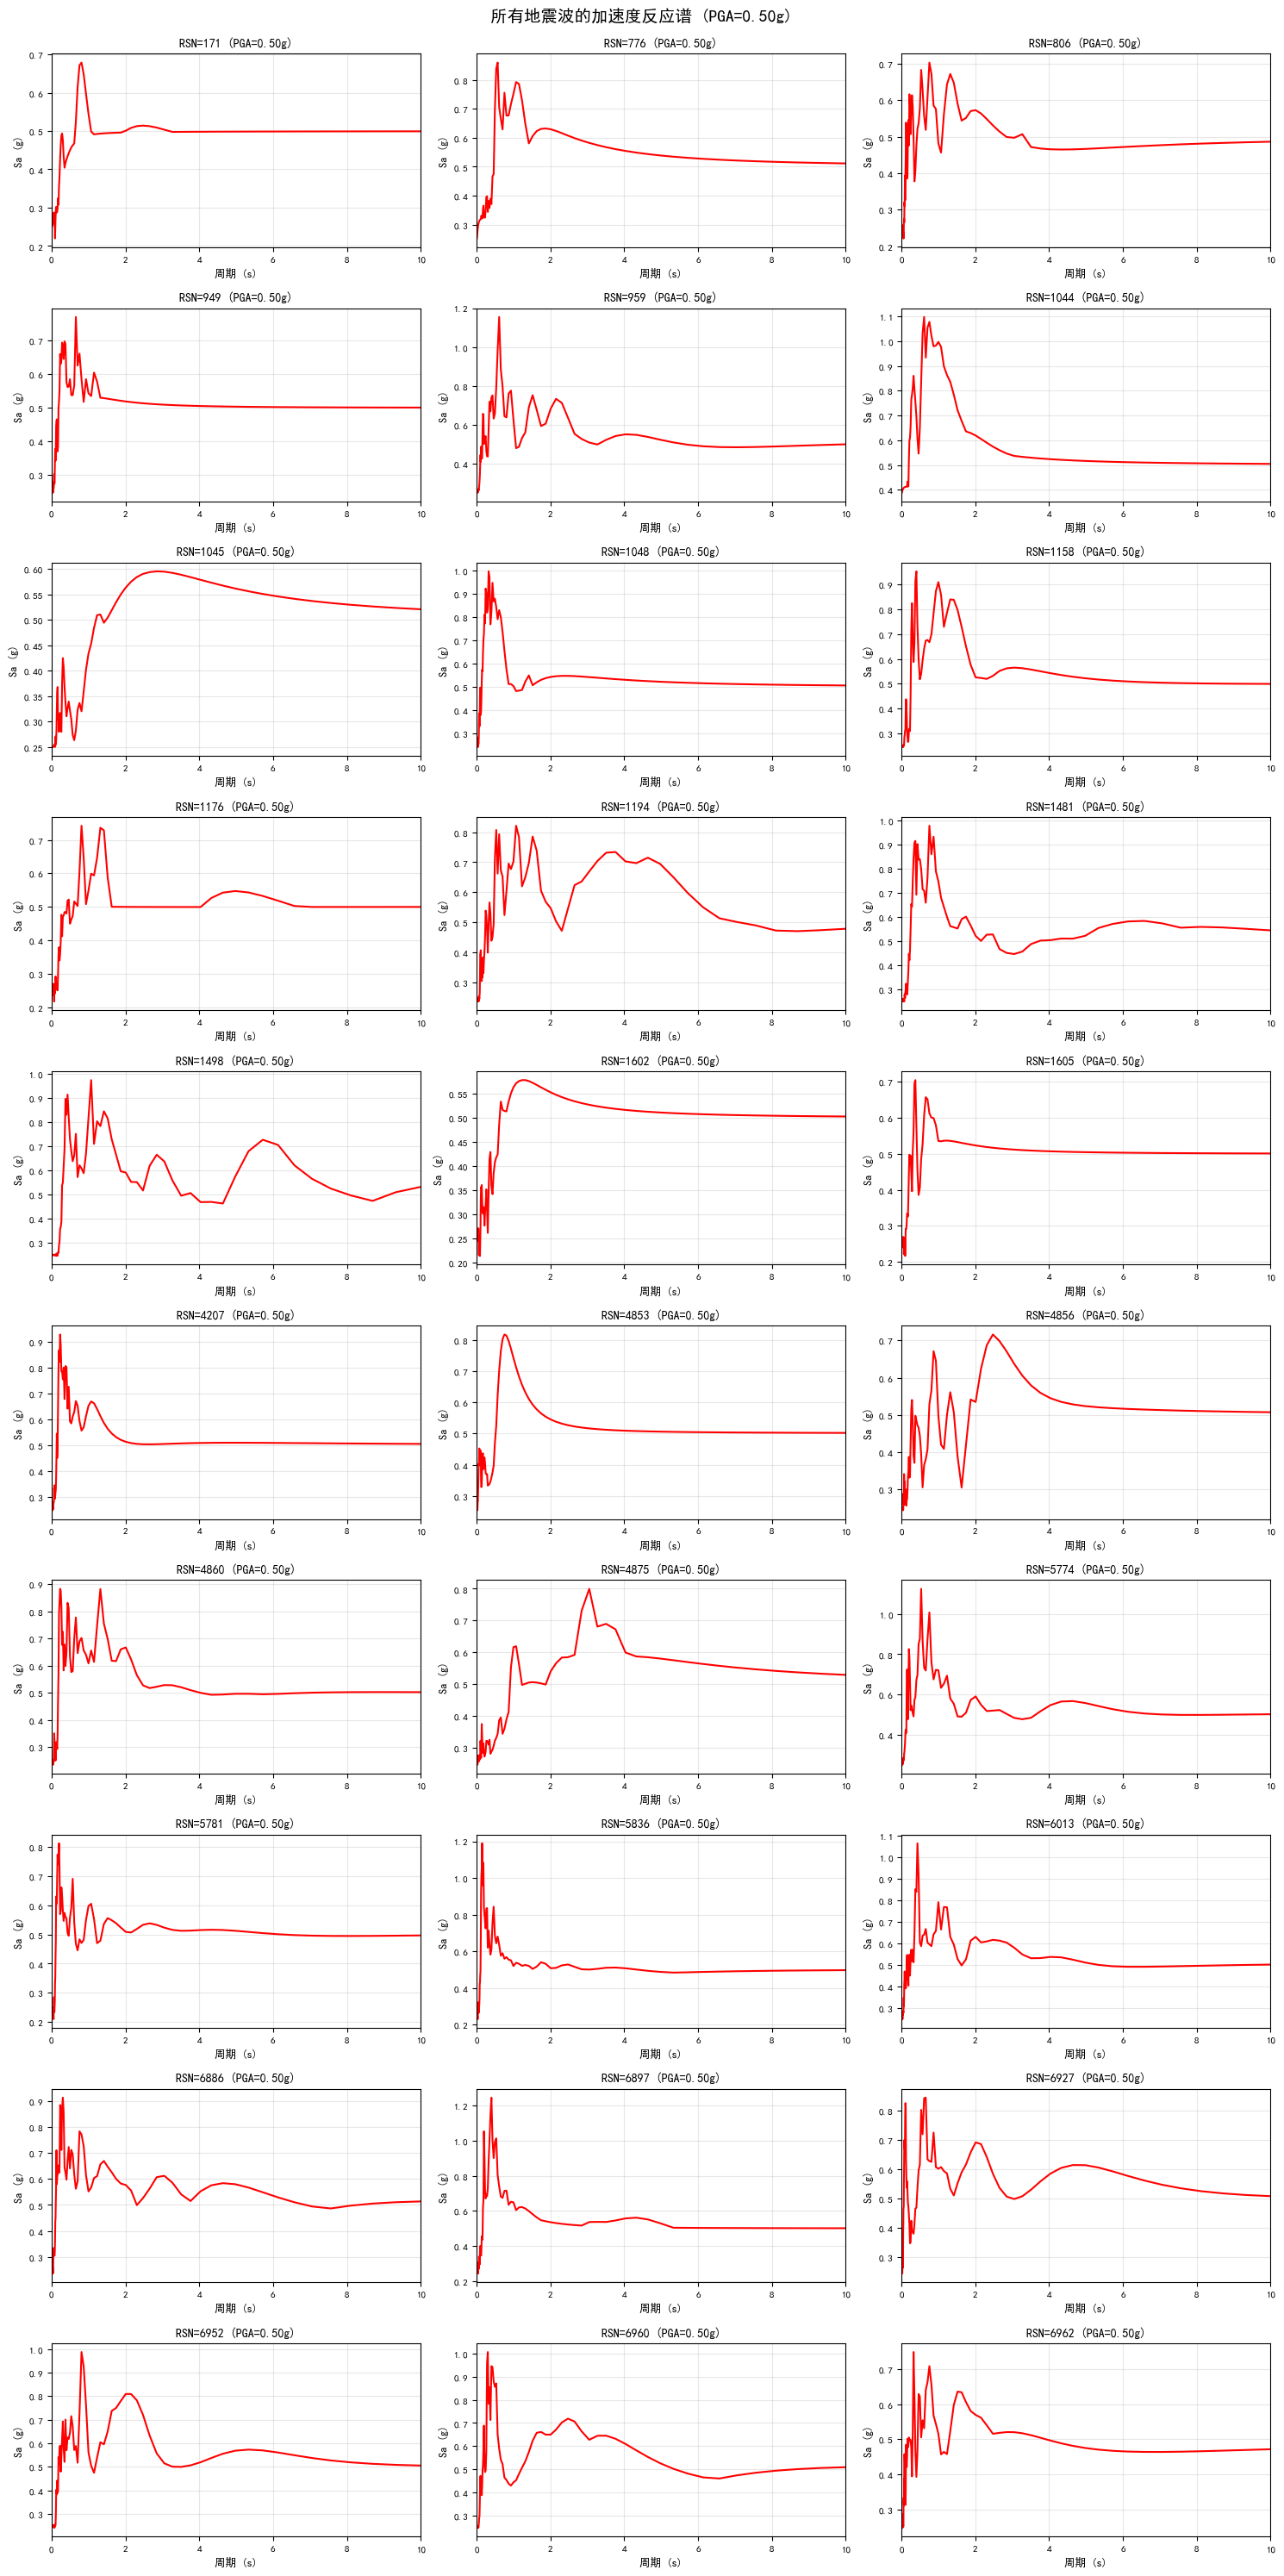

In [8]:
# 绘制所有地震波的反应谱
plot_all_response_spectra(
    all_Sa,
    periods,
    rsn_list,
    pga_value=selected_pga,
    save_path='ground_motions/response_spectra.png'
)

## 步骤 7: 绘制统计反应谱

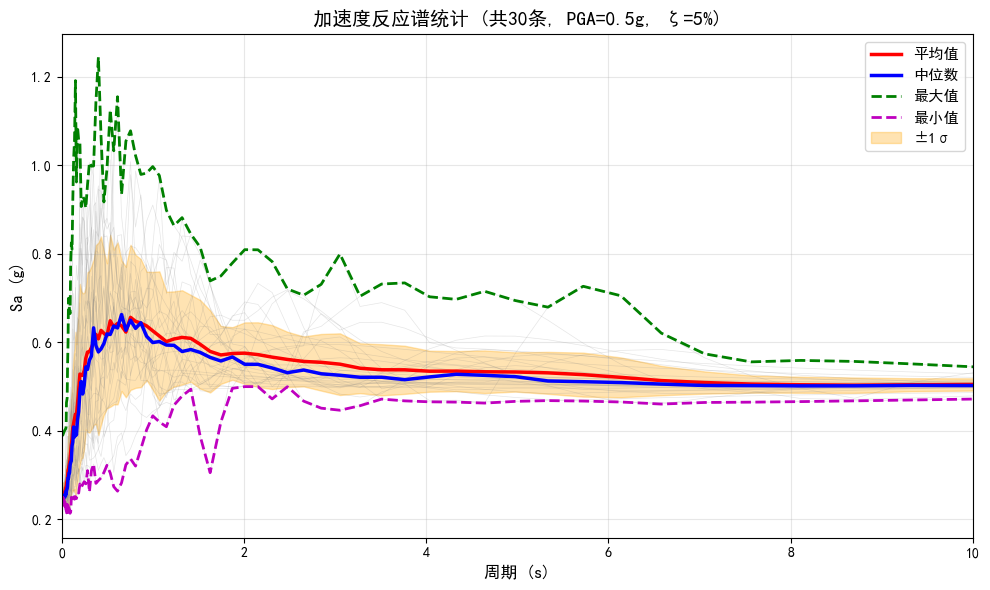

平均 PGA: 0.2569 g
中位数 PGA: 0.2513 g


In [9]:
# 计算统计值
Sa_mean = np.mean(all_Sa, axis=0)
Sa_median = np.median(all_Sa, axis=0)
Sa_max = np.max(all_Sa, axis=0)
Sa_min = np.min(all_Sa, axis=0)
Sa_std = np.std(all_Sa, axis=0)

# 绘制统计反应谱
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制所有反应谱（半透明）
for i in range(len(all_Sa)):
    ax.plot(periods, all_Sa[i], 'gray', alpha=0.2, linewidth=0.5)

# 绘制统计曲线
ax.plot(periods, Sa_mean, 'r-', linewidth=2.5, label='平均值')
ax.plot(periods, Sa_median, 'b-', linewidth=2.5, label='中位数')
ax.plot(periods, Sa_max, 'g--', linewidth=2, label='最大值')
ax.plot(periods, Sa_min, 'm--', linewidth=2, label='最小值')
ax.fill_between(periods, Sa_mean - Sa_std, Sa_mean + Sa_std, 
                alpha=0.3, color='orange', label='±1σ')

ax.set_xlabel('周期 (s)', fontsize=12)
ax.set_ylabel('Sa (g)', fontsize=12)
ax.set_title(f'加速度反应谱统计 (共{len(GMdata)}条, PGA={selected_pga}g, ζ=5%)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim([0, max(periods)])

plt.tight_layout()
plt.savefig('ground_motions/response_spectra_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'平均 PGA: {Sa_mean[0]:.4f} g')
print(f'中位数 PGA: {Sa_median[0]:.4f} g')